# Biodiversity Intactness Index Change in Phoenix from 2017 to 2020
### 

Maricopa County

Using the Micrsoft Planetary Computer, 2017 and 2020 rasters of the Phoenix subdivision were employed to study biodiversity loss in the Phoenix subdivision. In 2021, Maricopa County was documented as the leading US county in most developed land since 2001. 

Author: Kate Becker

Published: Dec 10, 2023

## Import important libraries, functions, and the Planetary Computer

In [136]:

import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import contextily as ctx
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import box
import xarray as xr

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image


## Catalog Access and Search for the Io-Biodiversity Collection

In [137]:
## Catalog search 
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                      modifier = planetary_computer.sign_inplace)
#temporal range of interest
time_range = '2017/2020'
#Bounding Box Coordinates (as a GeoJSON)
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
#Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)
items = search.item_collection()
items
#Number of items in the search:
len(items)

4

## Arizona Shapefile Read in and a View of Phoenix County

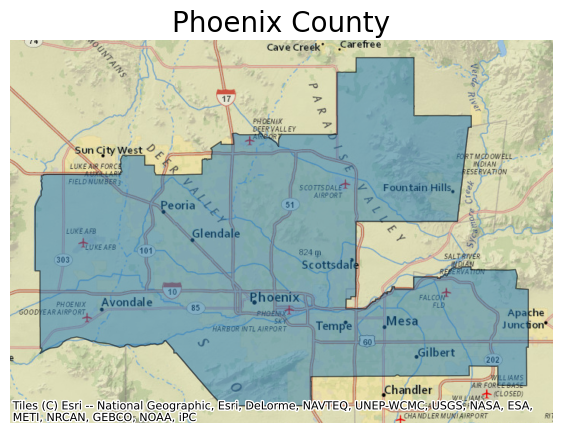

In [138]:
arizona = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
arizona.head()
phoenix = arizona[arizona['NAME'] == "Phoenix"]

# create axis with plot
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County", fontdict={"fontsize": "20"})
ax.set_axis_off()

## Metadata Access for the 2017 and 2020 STAC Items

In [139]:
items

In [140]:
ph_2017 = items[3]
ph_2020 = items[0]

In [141]:
ph_2017

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

In [142]:
ph_2020
#clip this to phenix geometry and plot 

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

## 2017 and 2020 Raster Access

In [143]:
ph_2017 = rioxr.open_rasterio(ph_2017.assets['data'].href)
ph_2020 = rioxr.open_rasterio(ph_2020.assets['data'].href)

## Phoenix Subdivision Biodiversity Index Analysis

In [149]:
bi_threshold = 0.75
above_thresh_2017 = ph_2017 >= bi_threshold 
above_thresh_2020 = ph_2020 >= bi_threshold

In [150]:
above_thresh_2017 = above_thresh_2017.astype(int)
above_thresh_2020 = above_thresh_2020.astype(int)

total_2017 = np.sum(ph_2017)
total_2017

total_2020 = np.sum(ph_2020)
total_2020 


<xarray.DataArray ()>
array(56007876., dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [151]:
percent_2017 = (np.sum(above_thresh_2017 / total_2017)) * 100  #diff variable when all vales are 1 over all pixels that are  and 1 
percent_2020 = (np.sum(above_thresh_2020 / total_2020)) * 100

percent_2017
percent_2020

<xarray.DataArray ()>
array(91.02281972)
Coordinates:
    spatial_ref  int64 0

In [152]:
lost_pixels = above_thresh_2017 - above_thresh_2020 
print(np.sum(lost_pixels))

<xarray.DataArray ()>
array(96266)
Coordinates:
    spatial_ref  int64 0


In [153]:
phoenix = phoenix.to_crs(lost_pixels.rio.crs)
phoenix.crs == lost_pixels.rio.crs

True

In [154]:
percent_2017 = (np.sum(above_thresh_2017 / lost_pixels)) * 100  #diff variable when all vales are 1 over all pixels that are  and 1 
percent_2020 = (np.sum(above_thresh_2020 / lost_pixels)) * 100

percent_2017
percent_2020

<xarray.DataArray ()>
array(inf)
Coordinates:
    spatial_ref  int64 0

In [155]:
lost_pixels = above_thresh_2017 - above_thresh_2020
print(np.sum(lost_pixels))

<xarray.DataArray ()>
array(96266)
Coordinates:
    spatial_ref  int64 0


In [156]:
phoenix = phoenix.to_crs(lost_pixels.rio.crs)

In [157]:
lost_pixels = lost_pixels.rio.clip(phoenix.geometry, phoenix.crs)
ph_2020 = ph_2020.rio.clip(phoenix.geometry, phoenix.crs)

#above_thresh_2017 = above_thresh_2020.rio.clip(phoenix.geometry, phoenix.crs)

/Users/katebecker/anaconda3/envs/mpc-env/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:201: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [158]:
type(lost_pixels)
type(phoenix)
type(above_thresh_2017)

xarray.core.dataarray.DataArray

In [159]:
# original dimensions and coordinates
print(ph_2020.dims, ph_2020.coords,'\n')

# remove length 1 dimension (band)
ph_2020 = ph_2020.squeeze()
print(ph_2020.dims, ph_2020.coords,'\n')

# remove coordinates associated to band
ph_2020 = ph_2020.drop('band')
print(ph_2020.dims, ph_2020.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0 

('y', 'x') Coordinates:
    band         int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0 

('y', 'x') Coordinates:
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0


In [160]:
ph_2020 = ph_2020.rio.clip(phoenix.geometry, phoenix.crs)

/Users/katebecker/anaconda3/envs/mpc-env/lib/python3.11/site-packages/xarray/plot/utils.py:245: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


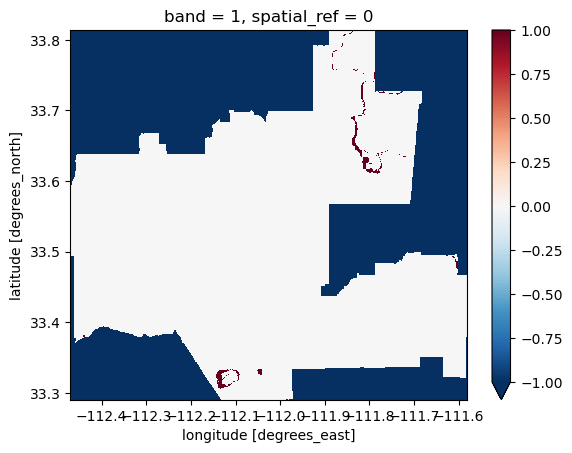

In [180]:
lost_pixels.plot() #i want to plot this and plot phoenix shapefile 

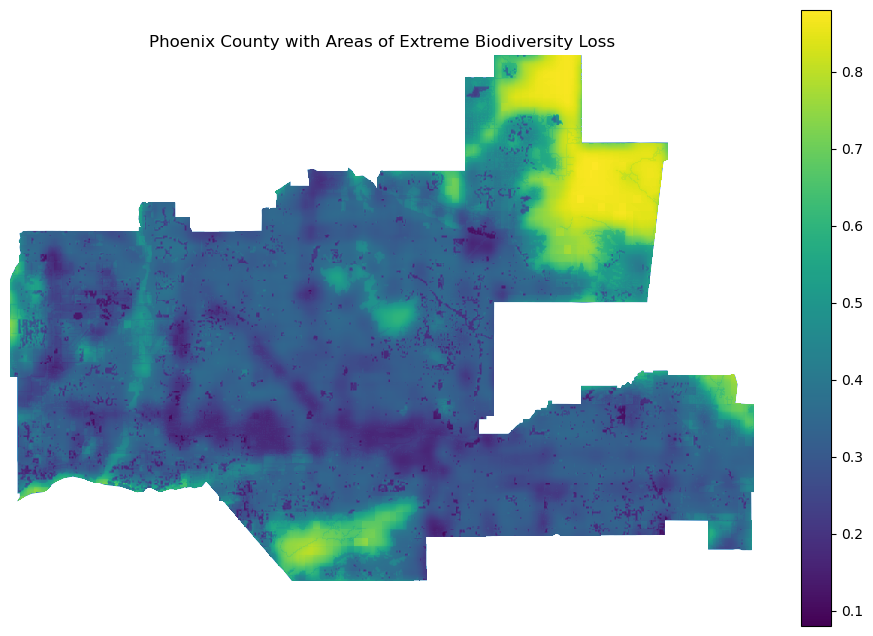

In [197]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

phoenix.plot(ax=ax)
ph_2020.plot(ax=ax)
lost_pixels.where(lost_pixels == 1)

plt.title('Phoenix County with Areas of Extreme Biodiversity Loss')

plt.show() 